In [2]:
import struct # complient with IEEE 754

def float_to_bits(num, precision='double'):
    """Convert float to binary string (32-bit single or 64-bit double precision)"""
    if precision == 'single':  # 32-bit
        packed = struct.pack('!f', num)
    else:  # 64-bit (default)
        packed = struct.pack('!d', num)
    return ''.join(f'{b:08b}' for b in packed)

def float_to_bits_unpacked(num, precision='double'):
    """Convert float to binary string (32-bit single or 64-bit double precision)"""
    if precision == 'single':  # 32-bit
        packed = struct.pack('!f', num)
    else:  # 64-bit (default)
        packed = struct.pack('!d', num)
    return {"sign": f'{packed[0]:08b}', "e":f'{packed[1]:08b}', "m":f'{packed[2]:08b}'}

# Example usage
print(float_to_bits(1.0, 'single'))
print(float_to_bits_unpacked(1.0, 'single'))
print(float_to_bits(-1.0, 'single'))


00111111100000000000000000000000
{'sign': '00111111', 'e': '10000000', 'm': '00000000'}
10111111100000000000000000000000


In [3]:

def float_to_ieee754(num, precision='single'):
    abbr = {"single": ['!f', '!L'], "double": ['!d', '!Q']}
    packed = struct.pack(abbr[precision][0], num)
    integer = struct.unpack(abbr[precision][1], packed)[0]
    
    book = {"single": [31, 23, 0xFF, 0x7FFFFF], "double": [63, 52, 0x7FF, 0xFFFFFFFFFFFFF]}
    v = book[precision]

    sign = (integer >> v[0]) & 0x01
    exponent = (integer >> v[1]) & v[2] 
    fraction = integer & v[3]  
    
    fill = {"single": [8, 23], "double": [11, 52]}
    return (    
        f"Sign: {sign}",
        f"Exponent (raw): {bin(exponent)[2:].zfill(fill[precision][0])}",
        f"Exponent: {exponent}",
        f"Fraction (raw): {bin(fraction)[2:].zfill(fill[precision][1])}",
        f"Fraction: {fraction}"
    )

# Example usage
sign, exp_r, exp, frac_r, frac = float_to_ieee754(11.0, precision='single')
print(f"{sign}\n{exp_r}\n{exp}\n{frac_r}\n{frac}")
sign, exp_r, exp, frac_r, frac = float_to_ieee754(2.0, precision='single')
print(f"{sign}\n{exp_r}\n{exp}\n{frac_r}\n{frac}")


Sign: 0
Exponent (raw): 10000010
Exponent: 130
Fraction (raw): 01100000000000000000000
Fraction: 3145728
Sign: 0
Exponent (raw): 10000000
Exponent: 128
Fraction (raw): 00000000000000000000000
Fraction: 0


In [4]:
import struct 

class number:
    def __init__(self, num):
        self.num = num
        self.pack()
        self.unpack()
        self.format()
    
    def pack(self):
        self.packed = struct.pack(self.abbr, self.num)
        return self.packed
        
    def unpack(self):
        self.unpacked = struct.unpack(self.form, self.pack())[0]
        return self.unpacked
    
class Int(number):
    def __init__(self, num):
        num = int(num)
        super().__init__(num)

    def format(self):
        self.sign = (self.unpacked >> self.sign_idx) & 0x01
        self.exp = (self.unpacked) & self.exp_size_hex
        self.exp_bin = bin(self.exp)[2:].zfill(self.exp_length)
        
        self.dec = (-1) ** self.sign * int(self.exp_bin, 2)
    
    def print(self):
        print(f"Num (dec): {self.num}\n",  
            f"Sign: {self.sign}\n",
            f"Exponent (bit): {self.exp_bin}\n",
            f"decimal: {self.dec}\n",)


# function for normal FP multiplication
class Float(number):
    def __init__(self, num):
        super().__init__(num)
    
    # according to IEEE 754 standard
    def format(self):
        self.sign = (self.unpacked >> self.sign_idx) & 0x01
        self.exp = (self.unpacked >> self.exp_idx) & self.exp_size_hex 
        self.exp_bin = bin(self.exp)[2:].zfill(self.exp_length)
        
        self.fraction = self.unpacked & self.fraction_size_hex 
        self.fraction_bin = bin(self.fraction)[2:].zfill(self.fraction_length) 
        
        self.exp_bias = 2 ** (self.exp_length - 1) - 1
        self.IEEE754_dec = (-1) ** self.sign * 2 ** (self.exp - self.exp_bias) * (1 + sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(self.fraction_bin))) 
    
    def print(self):
        print(f"Num (dec): {self.num}\n",  
            f"Sign: {self.sign}\n",
            f"Exponent (bit): {self.exp_bin}\n",
            f"Exponent: {self.exp}\n",
            f"Fraction (bit): {self.fraction_bin}\n",
            f"decimal: {self.IEEE754_dec}\n",)
    
class Float32(Float):
    def __init__(self, num):
        self.abbr = '!f'
        self.form = '!L'
        self.bits = 32
        self.sign_idx = 31
        self.exp_idx = 23
        self.exp_size_hex = 0xFF
        self.fraction_size_hex = 0x7FFFFF
        self.exp_length = 8
        self.fraction_length = 23
        
        super().__init__(num)
        
class Int32(Int):
    def __init__(self, num):
        self.abbr = '!i'
        self.form = '!L'
        self.bits = 32
        self.sign_idx = 31
        self.exp_idx = 0
        self.exp_size_hex = 0x7FFFFFFF
        self.exp_length = 31
        
        super().__init__(num)
        
        
class Float64(Float):
    def __init__(self, num):
        self.abbr = '!d'
        self.form = '!Q'
        self.bits = 64
        self.sign_idx = 63       
        self.exp_idx = 52        
        self.exp_size_hex = 0x7FF
        self.fraction_size_hex = 0xFFFFFFFFFFFFF
        self.exp_length = 11
        self.fraction_length = 52
        
        super().__init__(num)


In [9]:
def Float2Int(fnum):
    """Convert float to int"""
    temp = Int32(fnum.num)
    temp.sign = fnum.sign
    temp.exp_bin = fnum.exp_bin + fnum.fraction_bin
    temp.exp = int(temp.exp_bin.zfill(temp.exp_length), 2)
    temp.dec = (-1) ** temp.sign * int(temp.exp_bin, 2)
    return temp

a = Float32(5.0)
b = Int32(5)
c = Float2Int(a)

a.print()
b.print()
c.print()


Num (dec): 5.0
 Sign: 0
 Exponent (bit): 10000001
 Exponent: 129
 Fraction (bit): 01000000000000000000000
 decimal: 5.0

Num (dec): 5
 Sign: 0
 Exponent (bit): 0000000000000000000000000000101
 decimal: 5

Num (dec): 5
 Sign: 0
 Exponent (bit): 1000000101000000000000000000000
 decimal: 1084227584



In [10]:
def FPmul(A, B, precision='single'):
    if precision=='single': 
        x = Float32(A)
        y = Float32(B)
    else:
        x = Float64(A)
        y = Float64(B)
    x_s = x.sign
    y_s = y.sign
    x_e = (x.exp - x.exp_bias)
    y_e = (y.exp - y.exp_bias)
    x_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(x.fraction)[2:].zfill(x.fraction_length)))
    y_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(y.fraction)[2:].zfill(y.fraction_length)))
    return (1 + x_m + y_m + x_m * y_m) * 2**(x_e + y_e)

def l_operator(x):
    offset = lambda x: 2 ** (-x)
    if x.fraction_length <= 3:
        x_l = offset(x.fraction_length)
    elif x.fraction_length == 4:
        x_l = offset(x.fraction_length)
    else:
        x_l = offset(4) 
    return x_l

def Lmul(A, B, precision='single'):
    if precision=='single': 
        x = Float32(A)
        y = Float32(B)
    else:
        x = Float64(A)
        y = Float64(B)
    x_s = x.sign
    y_s = y.sign
    x_e = (x.exp - x.exp_bias)
    y_e = (y.exp - y.exp_bias)
    
    l = l_operator(x)
    
    x_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(x.fraction)[2:].zfill(x.fraction_length)))
    y_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(y.fraction)[2:].zfill(y.fraction_length)))
    return (1 + x_m + y_m + l) * 2**(x_e + y_e)

print(FPmul(5,5))   
print(Lmul(3,4))


25.0
12.5


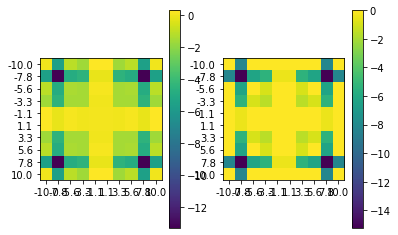

In [37]:
import matplotlib.pyplot as plt
import numpy as np

N = 10
precision = 'single'
num_abs_range = 10
x_range = np.linspace(-num_abs_range, num_abs_range, N)
y_range = np.linspace(-num_abs_range, num_abs_range, N)

X, Y = np.meshgrid(x_range, y_range)
z = np.zeros(X.shape)
k = np.zeros(X.shape)

for i, x_row in enumerate(X):
    for j, x in enumerate(x_row):
            y = Y[i, j]
            gt = Lmul(x, y, precision=precision) 
            z[i, j] = gt - FPmul(x, y, precision=precision)
            
            a_int = Float2Int(Float32(x))
            b_int = Float2Int(Float32(y))

            sign = (a_int.sign ^ b_int.sign) & 0x80000000

            digits = (a_int.exp + b_int.exp - 0x3F780000) & 0x7FFFFFFF 

            exp = (digits >> 23) & 0xFF
            fraction = digits & 0x7FFFFF

            fraction_bin = bin(fraction)[2:].zfill(23)
            exp_bias = 127

            k[i, j] = gt - (-1) ** sign * 2 ** (exp - exp_bias) * (1 + sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(fraction_bin)))


fig, axs = plt.subplots(1,2)

id2plot = {1:z, 2:k}

x_labels = [f"{x:.1f}" for x in x_range]
y_labels = [f"{y:.1f}" for y in y_range]

im= axs[0].imshow(z, cmap='viridis')
fig.colorbar(im, ax=axs[0])
im= axs[1].imshow(k, cmap='viridis')
fig.colorbar(im, ax=axs[1])

for i, ax in enumerate(axs):
    ax.set_xticks(range(len(x_range)), labels=x_labels)
    ax.set_yticks(range(len(y_range)), labels=y_labels)

In [23]:
a = Float32(5)
b = Float32(5)

a_int = Float2Int(a)
b_int = Float2Int(b)

c = Float32(10)
c.print()

# a.print()
a_int.print()
# b.print()
b_int.print()

sign = (a_int.sign ^ b_int.sign) #& 0x80000000

digits = (a_int.exp + b_int.exp - 0x3F780000) & 0x7FFFFFFF 
print(digits, bin(digits))#[2:])#.zfill(31))

exp = (digits >> 23) & 0xFF
fraction = digits & 0x7FFFFF

fraction_bin = bin(fraction)[2:].zfill(23)
exp_bias = 127

print((-1) ** sign * 2 ** (exp - exp_bias) * (1 + sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(fraction_bin))))



Num (dec): 10
 Sign: 0
 Exponent (bit): 10000010
 Exponent: 130
 Fraction (bit): 01000000000000000000000
 decimal: 10.0

Num (dec): 5
 Sign: 0
 Exponent (bit): 1000000101000000000000000000000
 decimal: 1084227584

Num (dec): 5
 Sign: 0
 Exponent (bit): 1000000101000000000000000000000
 decimal: 1084227584

1103626240 0b1000001110010000000000000000000
25.0


In [22]:
Float32(4).print()

Num (dec): 4
 Sign: 0
 Exponent (bit): 10000001
 Exponent: 129
 Fraction (bit): 00000000000000000000000
 decimal: 4.0

